![Snow, trees, and mountain overlook Lake Tahoe](shap-thumbnail.jpg "")

In [176]:
from sklearn import datasets 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
import shap
import numpy as np 
import pandas as pd 

# a classic housing price dataset
# X, y = shap.datasets.california(n_points=1000)
data = datasets.fetch_california_housing(as_frame=True)
features, target = data.feature_names, data.target_names[0] 
df = data.frame 

n= 1000
x1 = np.random.normal(size=n)
x2 = np.random.normal(size=n)
x3 = np.random.normal(size=n)
y = 5 + 2*x1 -4*x2 + 1*x3 
df = pd.DataFrame(dict(x1=x1, x2=x2, x3=x3, y=y)) 
features = ['x1', 'x2', 'x3'] 
target = 'y' 


# sample data for shap computations 
X_sample = df.sample(100, random_state=0)[features]

# a simple linear model
model = LinearRegression()
# model = GradientBoostingRegressor()


model.fit(df[features], df[target]);

In [177]:
explainer = shap.Explainer(model, X_sample)
shap_values = explainer(X_sample)

In [178]:
# build an Exact explainer and explain the model predictions on the given dataset
explainer = shap.explainers.Exact(model.predict, X_sample)
shap_values = explainer(X_sample)

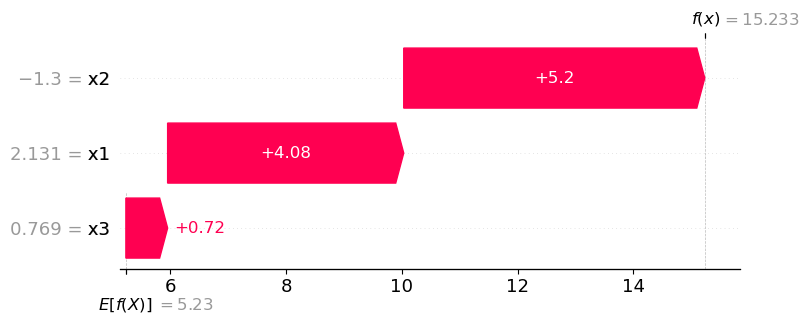

In [179]:
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
sample_ind = 10
shap.plots.waterfall(shap_values[sample_ind]);

In [180]:
print(f'E[f(x)]= {model.predict(X_sample).mean()}')
print(f'f(x) = {model.predict(X_sample)[sample_ind]}')

E[f(x)]= 5.2304846733785375
f(x) = 15.232590690048763


In [181]:
print('Exact SHAP values based on linear model coefficients')

for i, f in enumerate(features):
    sv = model.coef_[i] * (X_sample.iloc[sample_ind, i] - X_sample.iloc[:, i].mean())
    print(f'exact shap value for {f} = {sv}')

Exact SHAP values based on linear model coefficients
exact shap value for x1 = 4.079283444632932
exact shap value for x2 = 5.201540243626524
exact shap value for x3 = 0.7212823284107706


## Shapley Regression Values

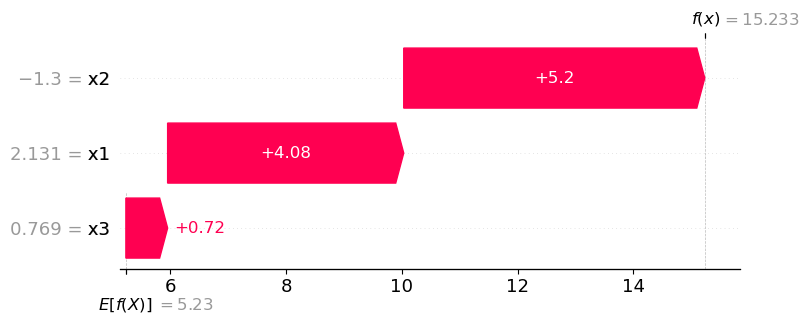

coalition = []
.   f_coalition_with_x1(x) - f_coalition(x) = 4.2295520787664636
.   scaling factor = 0.3333333333333333
.   summand = scaling factor * difference = 1.4098506929221544
coalition = ['x2']
.   f_coalition_with_x1(x) - f_coalition(x) = 4.14135132246456
.   scaling factor = 0.16666666666666666
.   summand = scaling factor * difference = 0.69022522041076
coalition = ['x3']
.   f_coalition_with_x1(x) - f_coalition(x) = 4.498008337809549
.   scaling factor = 0.16666666666666666
.   summand = scaling factor * difference = 0.7496680563015914
coalition = ['x2', 'x3']
.   f_coalition_with_x1(x) - f_coalition(x) = 4.221692533614803
.   scaling factor = 0.3333333333333333
.   summand = scaling factor * difference = 1.4072308445382675
shap value for x1 = 4.256974814172773
coalition = []
.   f_coalition_with_x2(x) - f_coalition(x) = 5.056518666881328
.   scaling factor = 0.3333333333333333
.   summand = scaling factor * difference = 1.6855062222937758
coalition = ['x1']
.   f_coalition

In [184]:
from math import factorial
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    c = chain.from_iterable(combinations(s, r) for r in range(len(s)+1))
    return list(c)

# features = ['MedInc', 'HouseAge', 'AveBedrms']

model = LinearRegression()
# model = GradientBoostingRegressor()
model.fit(df[features], df[target]);

# X_sample = df[features].sample(100, random_state=0)
# X_sample = df[features]
explainer = shap.Explainer(model, X_sample)
shap_values = explainer(X_sample)
# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
sample_ind = 10
shap.plots.waterfall(shap_values[sample_ind]);


num_features = len(features)

svs = [] 
for feature in features:
    # feature = 'MedInc' 
    # feature = 'HouseAge' 
    # feature = 'AveBedrms' 
    other_features = [f for f in features if f != feature]

    coalitions = powerset(other_features)

    summands = []
    for coalition in coalitions:
            
        coalition = list(coalition)
        num_coalition_features = len(coalition) 
        coalition_with_feature = coalition + [feature] 

        print(f'coalition = {coalition}')

        if len(coalition) > 0:
            model_without_feature = LinearRegression()
            model_without_feature.fit(df[coalition], df[target]);
            preds_without_feature = model_without_feature.predict(X_sample[coalition])
        else:
            model_mean_response = model.predict(X_sample).mean()
            preds_without_feature = model_mean_response

        model_with_feature = LinearRegression()
        model_with_feature.fit(df[coalition_with_feature], df[target]);
        preds_with_feature = model_with_feature.predict(X_sample[coalition_with_feature])

        pred_diffs = preds_with_feature - preds_without_feature
        difference = pred_diffs[sample_ind]
        scaling_factor = factorial(num_coalition_features) * factorial(num_features - num_coalition_features - 1) / factorial(num_features)
        summand = scaling_factor * difference 
        summands.append(summand)
        print(f'.   f_coalition_with_{feature}(x) - f_coalition(x) = {difference}')
        print(f'.   scaling factor = {scaling_factor}')
        print(f'.   summand = scaling factor * difference = {summand}')

    phi = np.sum(np.array(summands))
    print(f'shap value for {feature} = {phi}')
    svs.append(phi)

In [185]:
for i, f in enumerate(features): 
    print(f'shap value for {f} = {svs[i]}')

shap value for x1 = 4.256974814172773
shap value for x2 = 5.020457078556609
shap value for x3 = 0.7246741239408296


In [186]:
sum(svs), model.predict(X_sample)[sample_ind] - model.predict(X_sample).mean()

(10.002106016670211, 10.002106016670226)

So the shapley regression values don't quite recover the exact shap values computed from the model coefficients, and also they don't quite match the SHAP library values either.
I think the inconsistency is that the masked model in shapley regression values is a separate model trained with a subset of features, whereas SHAP uses conditional expectations over the excluded features to compute the masked model.

## Shapley sampling values

This is from Strumbeldj et al 2014. The shap paper notes that this approach can be used to estimate the shap values.

Now it looks to me like the real contribution of the shap paper is kernel shap, which is a much faster way to approximate the shap values. 